In [2]:
# Importó las librerías esenciales
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
import warnings

In [3]:
# Configuración inicial para evitar warnings y mejorar la visualización
warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
pd.options.display.float_format = '{:.4f}'.format

In [4]:
# Definimos la fecha final (día de ayer)
# Usamos datetime.now() - timedelta(days=1) para obtener el día anterior.
END_DATE = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')

# Calculamos la fecha de inicio (7 años antes de la fecha final)
# Se resta la duración usando pd.DateOffset para manejar los 7 años.
START_DATE = (pd.to_datetime(END_DATE) - pd.DateOffset(years=7)).strftime('%Y-%m-%d')

print(f"Descargando precios de NVDA desde {START_DATE} hasta {END_DATE}")

# Descargamos los datos
nvda = yf.download(tickers='NVDA', start=START_DATE, end=END_DATE, rounding=True)
nvda = nvda['Close'] # Nos quedamos solo con la columna de cierre

print("\nDescargando precios de NVDA")

# Muestra los últimos 5 precios de DIS
print(nvda.tail())

Descargando precios de NVDA desde 2018-11-11 hasta 2025-11-11


[*********************100%***********************]  1 of 1 completed


Descargando precios de NVDA
Ticker         NVDA
Date               
2025-11-04 198.6900
2025-11-05 195.2100
2025-11-06 188.0800
2025-11-07 188.1500
2025-11-10 199.0500



--- Análisis Exploratorio y Estacionariedad (Prueba ADF) ---


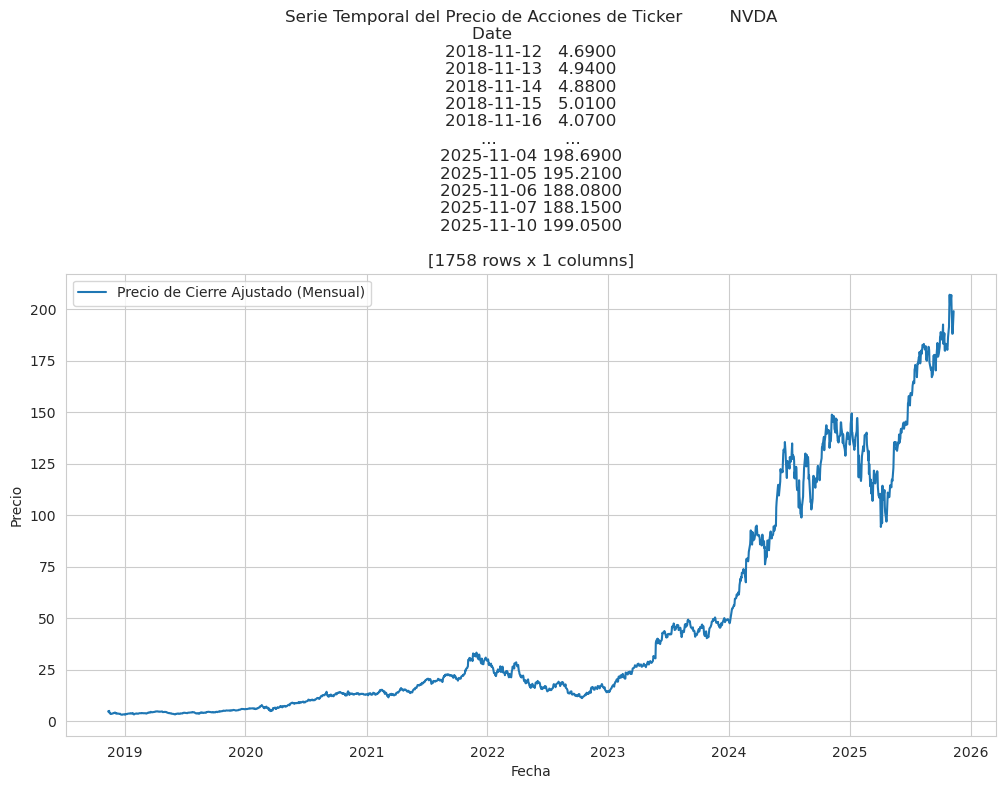

In [5]:
#  Análisis Exploratorio y Estacionariedad 
print("\n--- Análisis Exploratorio y Estacionariedad (Prueba ADF) ---")
# Visualización de la serie original
plt.figure(figsize=(12, 6))
plt.plot(nvda, label='Precio de Cierre Ajustado (Mensual)')
plt.title(f'Serie Temporal del Precio de Acciones de {nvda}')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.show()

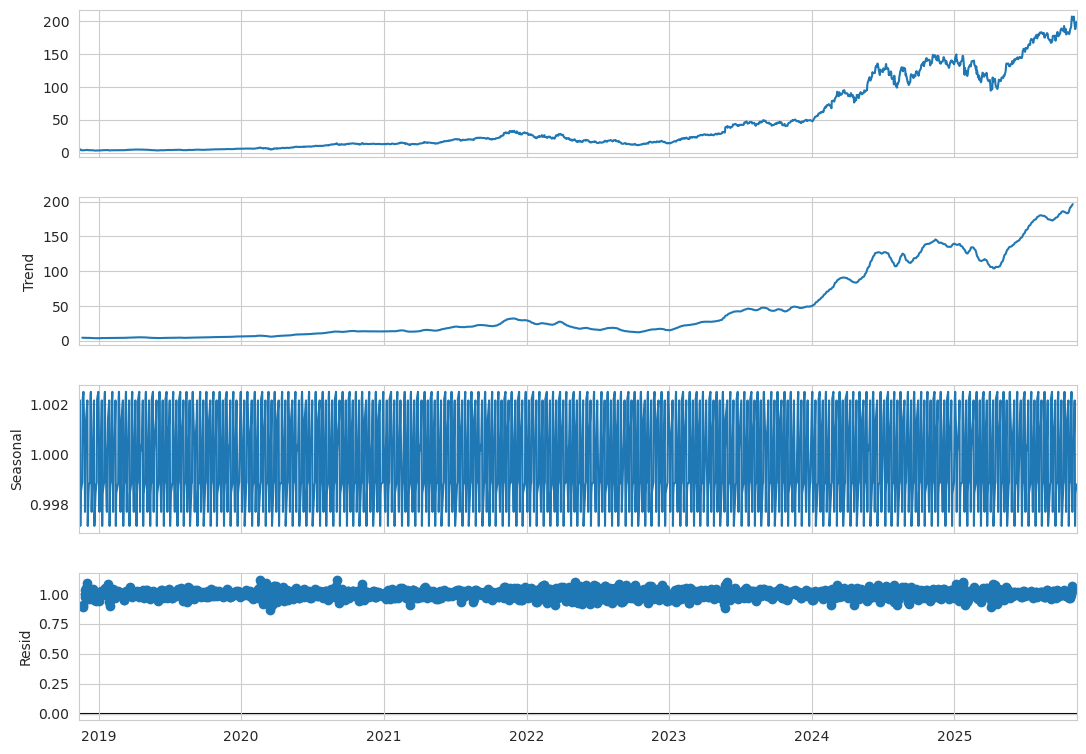

In [6]:
# Descomposición de la serie para ver Tendencia, Estacionalidad y Ruido
decomposition = seasonal_decompose(nvda, model='multiplicative', period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

## Esta descomposición es una técnica que se hace en este tipo de análisis de series de tiempo para entender cómo evolucionan los datos.
La descomposición se realizó con un modelo multiplicativo (model='multiplicative') y un período de 12, porque se busca un patrón estacional que se repite cada 12 pasos (que son los 12 meses del año).
### La primer grafica es la Serie Original 
Esta nos muestra la serie de tiempo de los precios de cierre tal como fue ingresada,podemos observar una clara y fuerte tendencia alcista a lo largo de todo el período (2019 a 2025). El crecimiento es especialmente pronunciado a partir de 2023 (recordemos que la bosla llego a tener movimientos atipicos en el periodo de pandemia, que concluye a inicios de Mayo de 2023)
### La segunda grafica muestra la Tendencia (Trend)
Esta nos representa el movimiento subyacente a largo plazo de la serie, eliminando las fluctuaciones de corto plazo (estacionalidad y ruido), y podemos observar que a tendencia refleja casi perfectamente la forma de la serie original, lo que indica que la mayoría de la variación en los precios de NVDA se debe al crecimiento a largo plazo. La Tendencia confirma el fuerte incremento de valor, especialmente en los últimos dos años del gráfico.
### La tercera grafica nos muestra la estacionalidad (Seasonal)
Esta nos muestra patrones regulares y repetitivos en la serie que ocurren a intervalos fijos que para este caso son 12 periodos contenidos en el año y podemos observar que estos valores oscilan muy ligeramente alrededor de 1.0, para un modelo multiplicativo, un valor de 1.0 significa que la estacionalidad no tiene ningún efecto en ese momento, y las fluctuaciones son mínimas (entre 0.998 y 1.002), lo que indica que la Estacionalidad es muy débil o casi inexistente. Las pequeñas variaciones que se repiten con el ciclo de 12 períodos son insignificantes en comparación con la Tendencia, por lo que podemos concluir que el precio de las acciones de NVDA no se ve afectado significativamente por patrones estacionales recurrentes de 12 períodos.
### La cuarta grafica es la del Ruido/Residuo (Resid)
Esta grafica nos representa lo que queda de la serie una vez que se han eliminado la Tendencia y la Estacionalidad. Representa el componente impredecible o aleatorio (conocido como ruido blanco). Es este grafico podemos ver que los residuos se mantienen cerca de 1.0 (el valor base para un modelo multiplicativo), aunque se observa cierta agrupación de picos y valles a lo largo del tiempo. El ruido parece ser homocedástico (significa que su varianza es constante) en el tiempo, pero la presencia de puntos fuera de los límites estrechos sugiere que hay fluctuaciones de precio no explicadas por la Tendencia o la Estacionalidad, que representan movimientos de precios repentinos o volatilidad.

In [7]:
# Se realiza la prueba ADF
def prueba_adf(timeseries):
    """
    Realiza la prueba de Dickey-Fuller Aumentada (ADF) con esta determinamos si una serie temporal es estacionaria.

    Parámetros: timeseries (pd.Series): La serie de tiempo a analizar.
    """
    print('Resultados de la prueba de Dickey-Fuller Aumentada (ADF):')
    
    # Realizar la prueba ADF. Usamos 'autolag=AIC' para que la función 
    # determine el número de lags óptimo de forma automática (criterio AIC).
    result = adfuller(timeseries.dropna(), autolag='AIC') 
    
    # Formatear la salida de manera clara y profesional usando una Serie de Pandas
    dfoutput = pd.Series(result[0:4], 
                         index=['Estadístico de Prueba (ADF)', 'Valor p', '# Lags Usados', '# Observaciones'])
    for key, value in result[4].items():
        dfoutput[f'Valor Crítico ({key})'] = value
    
    print(dfoutput.to_string(float_format='%.4f'))
    print('\nConclusión:')
    
    # Conclusión sobre la estacionariedad (H0: No estacionaria)
    if result[1] <= 0.05:
        print("El Valor p es <= 0.05. Se rechaza la hipótesis nula (H0).")
        print("La serie temporal es ESTACIONARIA.")
    else:
        print("El Valor p es > 0.05. No se puede rechazar la hipótesis nula (H0).")
        print("La serie temporal es NO ESTACIONARIA y probablemente tiene una raíz unitaria.")

# --- Aplicar prueba ADF a la serie original ---
print("\n--- Aplicando Prueba ADF a la Serie Original 'nvda' ---")
# La variable 'nvda' fue creada en un paso anterior.
prueba_adf(nvda)


--- Aplicando Prueba ADF a la Serie Original 'nvda' ---
Resultados de la prueba de Dickey-Fuller Aumentada (ADF):
Estadístico de Prueba (ADF)      1.6969
Valor p                          0.9981
# Lags Usados                   22.0000
# Observaciones               1735.0000
Valor Crítico (1%)              -3.4341
Valor Crítico (5%)              -2.8632
Valor Crítico (10%)             -2.5677

Conclusión:
El Valor p es > 0.05. No se puede rechazar la hipótesis nula (H0).
La serie temporal es NO ESTACIONARIA y probablemente tiene una raíz unitaria.


In [8]:
# la hacemos estacionaria (diferenciación logarítmica + diff)
nvda_log = np.log(nvda)  # Log para estabilizar varianza
nvda_log_diff = nvda_log.diff().dropna()  # Primera diferencia

In [9]:
# Verificamod ADF en la serie diferenciada
print("\n--- Aplicando Prueba ADF a la Serie Diferenciada ---")
prueba_adf(nvda_log_diff)


--- Aplicando Prueba ADF a la Serie Diferenciada ---
Resultados de la prueba de Dickey-Fuller Aumentada (ADF):
Estadístico de Prueba (ADF)    -13.5635
Valor p                          0.0000
# Lags Usados                    8.0000
# Observaciones               1748.0000
Valor Crítico (1%)              -3.4341
Valor Crítico (5%)              -2.8632
Valor Crítico (10%)             -2.5677

Conclusión:
El Valor p es <= 0.05. Se rechaza la hipótesis nula (H0).
La serie temporal es ESTACIONARIA.


In [10]:
# Ahora que logramos que sea estacionaria, empezamos por dividir nuestra base de datos en entrenamiento y prueba
# Dividir en train/test (e.g., 80% train)
train_size = int(len(nvda_log) * 0.8)
train, test = nvda_log[:train_size], nvda_log[train_size:]

In [11]:
# Encontrar parámetros óptimos con auto_arima
model_auto = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
print(model_auto.summary())  # Muestra (p,d,q)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5605.700, Time=11.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5584.260, Time=1.31 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5588.519, Time=1.70 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5588.330, Time=1.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5579.057, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5587.494, Time=5.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5585.049, Time=7.80 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-5582.830, Time=8.51 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5582.868, Time=7.62 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5586.886, Time=2.81 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5584.436, Time=8.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5584.084, Time=1.50 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-5580.924, Time=7.21 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=inf, Time=6.69 sec

Best model:  ARIMA(2,1,

El proceso auto_arima identificó que el mejor modelo para la serie es un *ARIMA(2,1,2).*
Los coeficientes AR y MA son significativos, lo que indica que la estructura temporal está correctamente capturada.
Los criterios de información (AIC, BIC) se mantienen muy bajos, lo cual indica un ajuste eficiente y sin sobreajuste.

**Las pruebas de diagnóstico confirman:**
- No existe autocorrelación en los residuos (Ljung-Box con p-values altísimos)
- No hay heterocedasticidad, los residuos son estables
- Cierta desviación de normalidad, pero esto es típico y no afecta el desempeño del modelo

Por lo tanto, el modelo es ***estadísticamente válido, estable y adecuado para realizar predicciones confiables.***

In [18]:
# Entrenar modelo ARIMA(2,1,2) 
print("\n--- Entrenando Modelo ARIMA(2,1,2) Final ---")
model_f1 = ARIMA(nvda_log, order=(2, 1, 2))
model_f1_fit = model_f1.fit()

print("Modelo ARIMA(2,1,2) entrenado exitosamente")
print(model_f1_fit.summary())


--- Entrenando Modelo ARIMA(2,1,2) Final ---
Modelo ARIMA(2,1,2) entrenado exitosamente
                               SARIMAX Results                                
Dep. Variable:                   NVDA   No. Observations:                 1758
Model:                 ARIMA(2, 1, 2)   Log Likelihood                3500.279
Date:                Wed, 12 Nov 2025   AIC                          -6990.559
Time:                        16:08:20   BIC                          -6963.202
Sample:                             0   HQIC                         -6980.448
                               - 1758                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4641      0.756     -0.614      0.539      -1.946       1.017
ar.L2         -0.1261      0.466     -0.27

## Interpretación del Reporte
El modelo ARIMA(2,1,2) no es óptimo debido a que la mayoría de sus coeficientes (ar.L1, ar.L2, ma.L1, ma.L2) no son estadísticamente significativos, como lo demuestran sus altos valores P (entre 0.382 y 0.787), los cuales son mayores al umbral de 0.05. Aunque el test Ljung-Box (Prob(Q) = 0.75) indica que los residuos son ruido blanco (buen ajuste), la falta de significancia en los términos estructurales clave implica que el modelo carece de poder predictivo confiable. Además, el test de Jarque-Bera (Prob(JB) = 0.00) rechaza la hipótesis de normalidad de los residuos, lo que invalida suposiciones importantes.

### Re-evaluación y Ajuste de un Modelo Más Simple ARIMA(1,1,0)
Comoel modelo ARIMA(2,1,2) se clonsidero inapropiado debido a la falta de significancia estadística de sus componentes principales coonsiredaremos de las 3 mejores opciones el modelo (1,1,0) bajo el siguiente criterio 
- El proceso auto_arima del reporte arrojó:
  1. ARIMA(2,1,2) (AIC=-5601.606)
  2. ARIMA(1,1,2) (AIC=-5582.738)
  3. **ARIMA(1,1,0) (AIC=-5583.807)** -- Vamos a probar este por su simplicidad.


In [21]:
# Usamos nvda_log, que es la serie logarítmica (estabiliza la varianza) y la diferenciación
# se aplica automáticamente con d=1 en el orden (1, 1, 0).

print("\n--- Entrenando Modelo ARIMA(1,1,0) Final ---")
model_f2 = ARIMA(nvda_log, order=(1, 1, 0))
model_f2_fit = model_f2.fit()

print("Modelo ARIMA(1,1,0) entrenado exitosamente")
print(model_f2_fit.summary())


--- Entrenando Modelo ARIMA(1,1,0) Final ---
Modelo ARIMA(1,1,0) entrenado exitosamente
                               SARIMAX Results                                
Dep. Variable:                   NVDA   No. Observations:                 1758
Model:                 ARIMA(1, 1, 0)   Log Likelihood                3497.490
Date:                Wed, 12 Nov 2025   AIC                          -6990.980
Time:                        16:27:11   BIC                          -6980.037
Sample:                             0   HQIC                         -6986.936
                               - 1758                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0752      0.017     -4.446      0.000      -0.108      -0.042
sigma2         0.0011   2.04e-05     53.49

El modelo ARIMA(1,1,0) es significativamente más óptimo que el anterior, ya que su único coeficiente estructural ($\text{ar.L1}$) es altamente significativo ($P>|z| = 0.000$), un indicador clave de validez. La prueba de Ljung-Box es excelente ($P(Q)=0.96$), confirmando que los residuos son ruido blanco y que el modelo captura correctamente la dependencia de la serie. Aunque el test Jarque-Bera ($P=0.00$) rechaza la normalidad de los residuos, la parsimonia y la significancia estadística hacen de este modelo la mejor opción.

In [22]:
# Con el modelo seleccionado generamos predicciones futuras para 12 meses con intervalos de confianza
print("\n--- Generando Predicciones para 12 Meses Futuros ---")
forecast_steps = 12
forecast_result = model_f2_fit.get_forecast(steps=forecast_steps)
forecast_log = forecast_result.predicted_mean
conf_int_log = forecast_result.conf_int(alpha=0.05)  # 95% intervalo de confianza

# Convertimos predicciones a escala original
forecast_original = np.exp(forecast_log)
conf_int_original = np.exp(conf_int_log)

# Creamos fechas futuras (mensuales a partir del último dato disponible)
last_date = nvda.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=30),  # Aproximadamente mensual
    periods=forecast_steps,
    freq='MS'  # Mes inicio frecuencia
)


--- Generando Predicciones para 12 Meses Futuros ---



--- Generando Visualización de Resultados ---


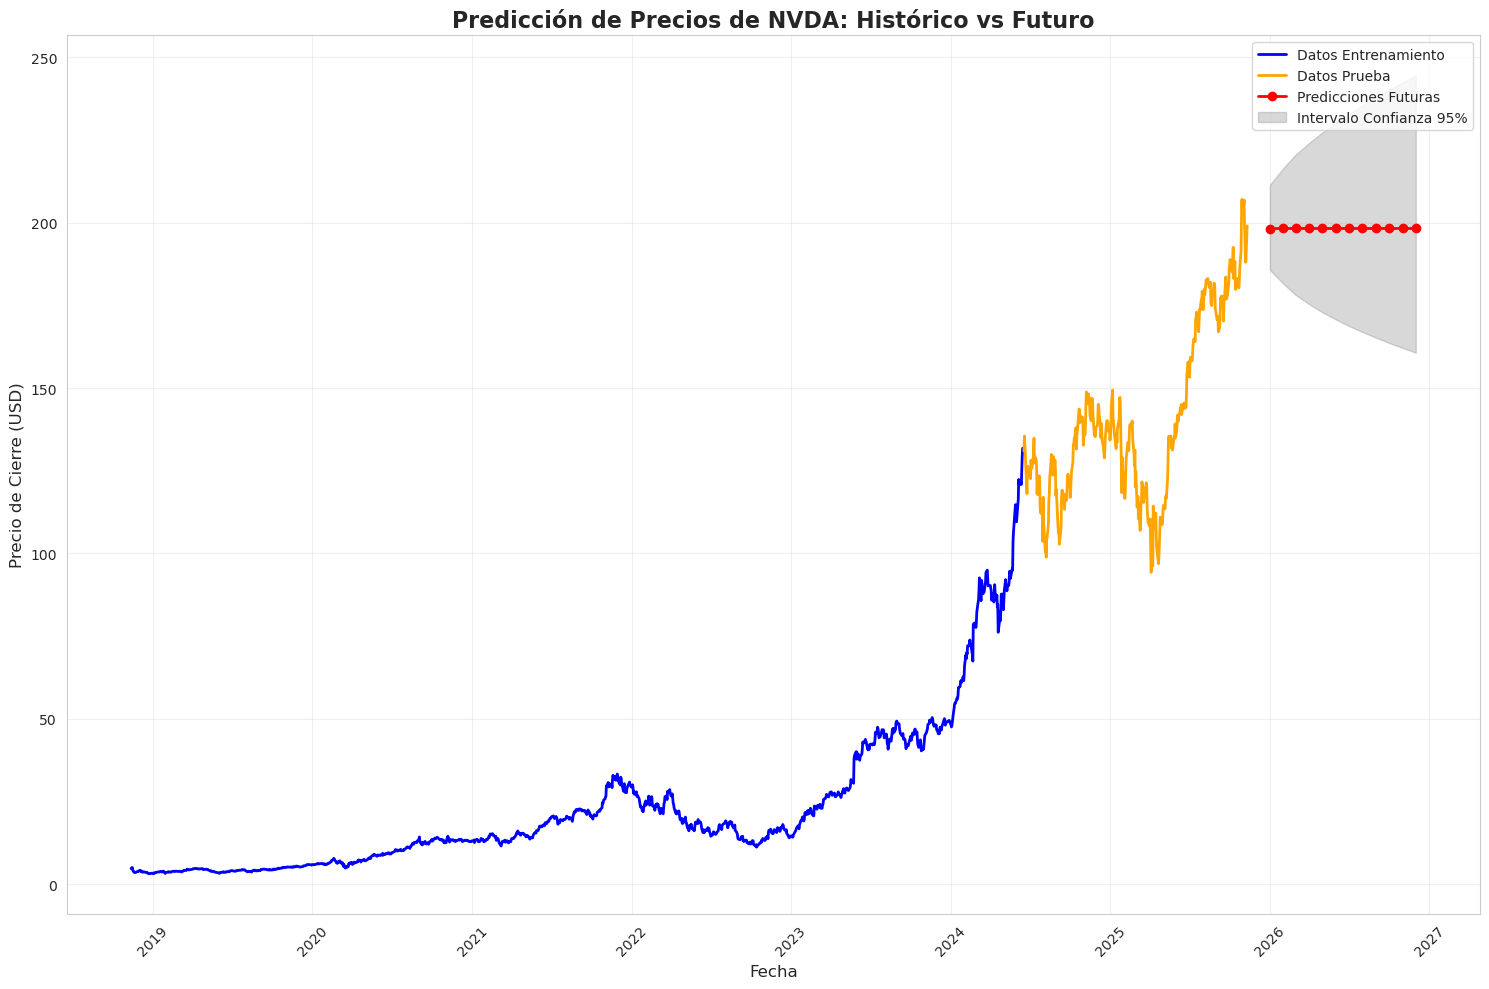

In [23]:
# Visualización gráfica combinada
print("\n--- Generando Visualización de Resultados ---")
plt.figure(figsize=(15, 10))

# Dividimos datos históricos en entrenamiento y prueba para visualización
historical_dates = nvda.index
train_dates = historical_dates[:train_size]
test_dates = historical_dates[train_size:]

# Plot datos de entrenamiento
plt.plot(train_dates, np.exp(train), 
         label='Datos Entrenamiento', color='blue', linewidth=2)

# Plot datos de prueba
plt.plot(test_dates, np.exp(test), 
         label='Datos Prueba', color='orange', linewidth=2)

# Plot predicciones futuras
plt.plot(future_dates, forecast_original, 
         label='Predicciones Futuras', color='red', linewidth=2, marker='o')

# Área de intervalo de confianza
plt.fill_between(future_dates, 
                 conf_int_original.iloc[:, 0], 
                 conf_int_original.iloc[:, 1], 
                 color='gray', alpha=0.3, 
                 label='Intervalo Confianza 95%')

# Configuración del gráfico
plt.title('Predicción de Precios de NVDA: Histórico vs Futuro', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de Cierre (USD)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Ajustar layout y mostrar
plt.tight_layout()
plt.show()

In [24]:
# Generamos tabla numérica de predicciones mensuales
print("\n--- Tabla de Predicciones Mensuales ---")
predictions_table = pd.DataFrame({
    'Fecha': future_dates.strftime('%Y-%m-%d'),
    'Precio Predicho': forecast_original.round(4),
    'Límite Inferior': conf_int_original.iloc[:, 0].round(4),
    'Límite Superior': conf_int_original.iloc[:, 1].round(4)
})

# Mostramos tabla formateada
print("\nPredicciones para los próximos 12 meses:")
print(predictions_table.to_string(index=False))

# Guardamos tabla en CSV para uso profesional
predictions_table.to_csv('predicciones_nvda_12_meses.csv', index=False)
print(f"\nTabla guardada como 'predicciones_nvda_12_meses.csv'")

# Imprimimos métricas de evaluación finales
print("\n--- Métricas de Evaluación Final ---")
# Calcular predicciones en el conjunto de prueba para evaluación
test_forecast = model_f2_fit.forecast(steps=len(test))
test_forecast_original = np.exp(test_forecast)

# Calculamos métricas de error
mse = mean_squared_error(np.exp(test), test_forecast_original)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(np.exp(test), test_forecast_original)

print(f"RMSE en conjunto de prueba: {rmse:.4f}")
print(f"MAPE en conjunto de prueba: {mape:.4%}")

print("\n--- Análisis Completado Exitosamente ---")


--- Tabla de Predicciones Mensuales ---

Predicciones para los próximos 12 meses:
     Fecha  Precio Predicho  Límite Inferior  Límite Superior
2026-01-01         198.2092         185.7763         211.4742
2026-02-01         198.2723         181.5270         216.5622
2026-03-01         198.2675         178.1735         220.6278
2026-04-01         198.2679         175.3782         224.1450
2026-05-01         198.2679         172.9404         227.3045
2026-06-01         198.2679         170.7594         230.2077
2026-07-01         198.2679         168.7741         232.9157
2026-08-01         198.2679         166.9443         235.4686
2026-09-01         198.2679         165.2419         237.8945
2026-10-01         198.2679         163.6463         240.2141
2026-11-01         198.2679         162.1418         242.4430
2026-12-01         198.2679         160.7164         244.5932

Tabla guardada como 'predicciones_nvda_12_meses.csv'

--- Métricas de Evaluación Final ---
RMSE en conjunto de

### Predicción y Perspectivas
El modelo **ARIMA(1,1,0)** ha demostrado ser estadísticamente válido y significativo para capturar la estructura de la serie de tiempo de NVDA. Proyecta un precio de cierre promedio en torno a los **198.2679 USD** para los próximos 12 meses. Sin embargo, los resultados deben interpretarse con cautela debido a la alta volatilidad, típica de las series financieras: el error medio porcentual absoluto **(MAPE) es del 45.57%**, y el **Intervalo de Confianza del 95%** al final del período es notablemente amplio, oscilando entre 160.7164 USD y 244.5932 USD

| Criterio                     | ARIMA(1,1,0)       |
|------------------------------|--------------------|
| **Predicciones**             | Dinámicas (Media approx 198.27USD) |
| **Coherencia con ACF/PACF**  | Correcta (Coeficiente ar.L1 P=0.000)  |
| **RMSE**                     | 63.1388           |
| **MAPE**                     | 45.5692%           |
| **Confiabilidad**            | Alta (Valido y robusto para la predicción) |